In [1]:
import pandas as pd
import numpy as np

import glob

from sklearn.cluster import KMeans

from fastai.tabular import *

import datetime

from math import radians, cos, sin, asin, sqrt, pi

from geographiclib.geodesic import Geodesic

import matplotlib.pyplot as plt 

from IPython.display import clear_output

In [2]:
!ls ../models

dev-fastai-999-balance.pkl  models
fastai-999		    traffic-cluster-density-20-kmeans.pkl
fastai-999.pkl		    traffic-cluster-speed-20-kmeans.pkl


In [3]:
density_kmeans = None
speed_kmeans = None

In [4]:
output_cols = [
    'origin_day', 'origin_hour', 'origin_day_sin', 'origin_day_cos', 'origin_hour_sin', 'origin_hour_cos',
    'origin_density_cluster', 'origin_speed_cluster',
    'origin_distance_from_density_center', 'origin_bearing_from_density_center',
    'origin_distance_from_speed_center', 'origin_bearing_from_speed_center',
    'dest_density_cluster', 'dest_speed_cluster',
    'dest_distance_from_density_center', 'dest_bearing_from_density_center',
    'dest_distance_from_speed_center', 'dest_bearing_from_speed_center',
    'distance_origin_dest', 'bearing_origin_dest',
    'distance_origin_dest_density_cluster', 'distance_origin_dest_speed_cluster',
    'origin_distance_from_density_center_squared', 'origin_distance_from_speed_center_squared',
    'dest_distance_from_density_center_squared', 'dest_distance_from_speed_center_squared',
    'distance_origin_dest_squared', 
    'distance_origin_dest_density_cluster_squared', 'distance_origin_dest_speed_cluster_squared',
    'day_hour_crossing', 
    'origin_dest_density_cluster_crossing', 'origin_dest_speed_cluster_crossing',
]

def load_kmeans():
    with open('../models/traffic-cluster-density-20-kmeans.pkl', 'rb') as pkl:
        global density_kmeans
        density_kmeans = pickle.load(pkl)
    with open('../models/traffic-cluster-speed-20-kmeans.pkl', 'rb') as pkl:
        global speed_kmeans
        speed_kmeans = pickle.load(pkl)

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def get_bearing(lat1, long1, lat2, long2):
    brng = Geodesic.WGS84.Inverse(lat1, long1, lat2, long2)['azi1']
    return brng

def preproc(row, c):
    dt = datetime.datetime.fromtimestamp(row['origin_timestamp'])
    row['origin_day'] = int(dt.weekday())
    row['origin_hour'] = int(dt.hour)
    row['origin_day_sin'] = round(sin(row['origin_day']*(pi/7)), 4)
    row['origin_day_cos'] = round(cos(row['origin_day']*(pi/7)), 4)
    row['origin_hour_sin'] = round(sin(row['origin_hour']*(pi/24)), 4)
    row['origin_hour_cos'] = round(cos(row['origin_hour']*(pi/24)), 4)
    
    row['origin_density_cluster'] = int(c['density'].predict([[row['origin_lat'], row['origin_lng']]])[0])
    row['origin_speed_cluster'] = int(c['speed'].predict([[row['origin_lat'], row['origin_lng']]])[0])
    origin_density_center = c['density'].cluster_centers_[int(row['origin_density_cluster'])]
    origin_speed_center = c['speed'].cluster_centers_[int(row['origin_speed_cluster'])]
    
    row['origin_distance_from_density_center'] = haversine(row['origin_lat'], row['origin_lng'], origin_density_center[0], origin_density_center[1])
    row['origin_bearing_from_density_center'] = get_bearing(row['origin_lat'], row['origin_lng'], origin_density_center[0], origin_density_center[1])
    row['origin_distance_from_speed_center'] = haversine(row['origin_lat'], row['origin_lng'], origin_speed_center[0], origin_speed_center[1])
    row['origin_bearing_from_speed_center'] = get_bearing(row['origin_lat'], row['origin_lng'], origin_speed_center[0], origin_speed_center[1])
    
    # dest data stuffs
    row['dest_density_cluster'] = int(c['density'].predict([[row['dest_lat'], row['dest_lng']]])[0])
    row['dest_speed_cluster'] = int(c['speed'].predict([[row['dest_lat'], row['dest_lng']]])[0])
    dest_density_center = c['density'].cluster_centers_[int(row['dest_density_cluster'])]
    dest_speed_center = c['speed'].cluster_centers_[int(row['dest_speed_cluster'])]
    
    row['dest_distance_from_density_center'] = haversine(row['dest_lat'], row['dest_lng'], dest_density_center[0], dest_density_center[1])
    row['dest_bearing_from_density_center'] = get_bearing(row['dest_lat'], row['dest_lng'], dest_density_center[0], dest_density_center[1])
    row['dest_distance_from_speed_center'] = haversine(row['dest_lat'], row['dest_lng'], dest_speed_center[0], dest_speed_center[1])
    row['dest_bearing_from_speed_center'] = get_bearing(row['dest_lat'], row['dest_lng'], dest_speed_center[0], dest_speed_center[1])
    
    # origin-destination stuffs
    row['distance_origin_dest'] = haversine(row['origin_lat'], row['origin_lng'], row['dest_lat'], row['dest_lng'])
    row['bearing_origin_dest'] = get_bearing(row['origin_lat'], row['origin_lng'], row['dest_lat'], row['dest_lng'])
    
    row['distance_origin_dest_density_cluster'] = haversine(origin_density_center[0], origin_density_center[1], dest_density_center[0], dest_density_center[1])
    row['distance_origin_dest_speed_cluster'] = haversine(origin_speed_center[0], origin_speed_center[1], dest_speed_center[0], dest_speed_center[1])
    
    row['origin_distance_from_density_center_squared'] = round(row['origin_distance_from_density_center'] ** 2, 4)
    row['origin_distance_from_speed_center_squared'] = round(row['origin_distance_from_speed_center'] ** 2, 4)
    row['dest_distance_from_density_center_squared'] = round(row['dest_distance_from_density_center'] ** 2, 4)
    row['dest_distance_from_speed_center_squared'] = round(row['dest_distance_from_speed_center'] ** 2, 4)
    row['distance_origin_dest_squared'] = round(row['distance_origin_dest'] ** 2, 4)
    row['distance_origin_dest_density_cluster_squared'] = round(row['distance_origin_dest_density_cluster'] ** 2, 4)
    row['distance_origin_dest_speed_cluster_squared'] = round(row['distance_origin_dest_speed_cluster'] ** 2, 4)
    
    row['day_hour_crossing'] = int(row['origin_day']*24 + row['origin_hour'])
    row['origin_dest_density_cluster_crossing'] = int(row['origin_density_cluster']*20 + row['dest_density_cluster'])
    row['origin_dest_speed_cluster_crossing'] = int(row['origin_speed_cluster']*20 + row['dest_speed_cluster'])
    
    return row

In [5]:
valid_df = pd.concat([pd.read_csv(f, encoding='latin1') for f in glob.glob('../data/validation/*.csv')])

In [6]:
valid_df = valid_df.rename(columns={ 
    'rawlat': 'origin_lat', 'rawlng': 'origin_lng', 'pingtimestamp': 'origin_timestamp',
    'rawlat2': 'dest_lat', 'rawlng2': 'dest_lng', 'pingtimestamp2': 'dest_timestamp',
})

In [7]:
valid_df_duration = valid_df.dest_timestamp - valid_df.origin_timestamp

In [8]:
load_kmeans()

/home/jjkoh/anaconda3/envs/ml-3.7/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KMeans from version 0.22.2.post1 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [9]:
for v in set(output_cols) - set(valid_df.columns):
    valid_df[v] = 0
    
cat_names = [
    "origin_day", "origin_hour",
    "origin_density_cluster", "origin_speed_cluster",
    "dest_density_cluster", "dest_speed_cluster",
    "day_hour_crossing", "origin_dest_density_cluster_crossing", "origin_dest_speed_cluster_crossing"
]

for v in cat_names:
    valid_df[v] = valid_df[v].astype('uint32')

In [10]:
valid_df = valid_df.apply(lambda row: preproc(row, {'density': density_kmeans, 'speed': speed_kmeans}), axis=1)

In [11]:
valid_df.head()

,origin_lat,origin_lng,origin_timestamp,dest_lat,dest_lng,dest_timestamp,origin_hour,dest_bearing_from_density_center,origin_dest_density_cluster_crossing,origin_distance_from_speed_center_squared,...,origin_distance_from_density_center,distance_origin_dest_speed_cluster_squared,dest_distance_from_density_center_squared,origin_density_cluster,origin_distance_from_density_center_squared,dest_distance_from_density_center,dest_density_cluster,origin_speed_cluster,distance_origin_dest_squared,origin_bearing_from_speed_center
0,1.340839,103.848598,1.554850e+09,1.344806,103.983101,1.554851e+09,6.0,-68.535168,208.0,3.1514,...,1.712340,203.9107,6.1363,10.0,2.9321,2.477152,8.0,11.0,223.7575,-145.981166
1,1.375949,103.854017,1.555030e+09,1.319886,103.881859,1.555031e+09,8.0,69.767056,280.0,0.9855,...,0.717754,75.6613,4.0140,14.0,0.5152,2.003487,0.0,14.0,48.4413,-49.568700
2,1.272912,103.843105,1.555585e+09,1.344893,103.716199,1.555587e+09,19.0,-34.295552,242.0,1.4648,...,1.176623,280.1149,1.7951,12.0,1.3844,1.339828,2.0,4.0,263.0874,-32.049059
3,1.318947,103.903400,1.555055e+09,1.360454,103.937541,1.555056e+09,15.0,106.589826,8.0,3.9661,...,0.953201,26.8272,8.3115,0.0,0.9086,2.882960,8.0,13.0,35.7054,76.587036
4,1.302866,103.893107,1.555326e+09,1.347796,103.957698,1.555327e+09,19.0,42.144536,68.0,3.3018,...,0.324433,90.4643,0.6066,3.0,0.1053,0.778862,8.0,6.0,76.5171,-64.233656


In [12]:
for v in cat_names:
    valid_df[v] = valid_df[v].astype('int64')

In [14]:
valid_df.to_pickle('valid_df.pkl')

In [30]:
learn = load_learner('../models/', 'dev-fastai-999-balance.pkl')

In [31]:
dicts = valid_df.to_dict('records')

In [32]:
i = 2020
learn.predict(dicts[i]), valid_df_duration.values[i]

((FloatItem [1205.503], tensor([1205.5031]), tensor([1205.5031])), 922)

In [33]:
learn.predict(dicts[i])[1].cpu().numpy()[0]

1205.503

In [34]:
res = {'actual': [], 'predicted': []}

In [35]:
for i, row in enumerate(dicts):
    print(i, len(dicts))
    clear_output(wait=True)
    pred = learn.predict(row)[1].cpu().numpy()[0]
    actual = valid_df_duration.values[i]
    res['actual'].append(actual)
    res['predicted'].append(pred)

27999 28000


In [36]:
res_df = pd.DataFrame.from_dict(res)

In [37]:
res_df.head()

,actual,predicted
0,1019,1036.233154
1,979,1026.076782
2,1629,1067.387573
3,1116,1073.095093
4,1075,992.388306


In [38]:
((res_df.predicted - res_df.actual) ** 2).mean() ** .5

397.4771463267267

In [39]:
temp_df = res_df[res_df.actual < 3000]
((temp_df.predicted - temp_df.actual) ** 2).mean() ** .5

360.4554413589786

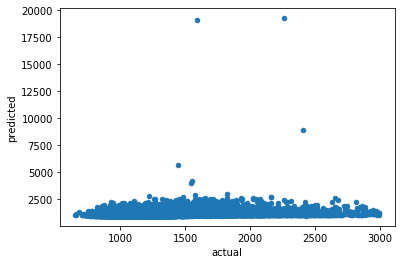

In [40]:
temp_df.plot.scatter(x='actual', y='predicted')

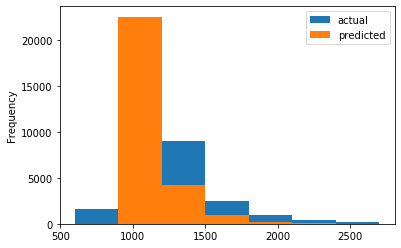

In [41]:
res_df.plot.hist(bins=np.arange(600, 3000, 300))

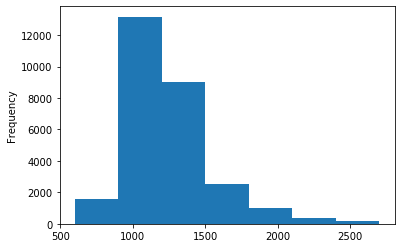

In [42]:
res_df.actual.plot.hist(bins=np.arange(600, 3000, 300))

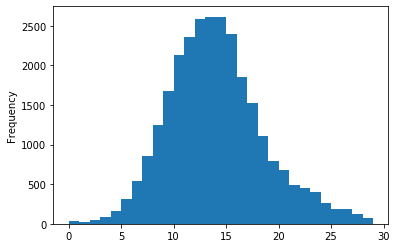

In [43]:
valid_df.distance_origin_dest.plot.hist(bins=np.arange(0, 30, 1))

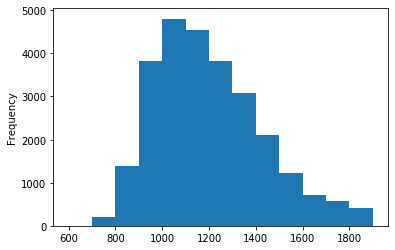

In [44]:
valid_df_duration.plot.hist(bins=np.arange(600, 2000, 100))